In [1]:
# ==========================================
# 1. SETUP AND DATA LOADING
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import joblib
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# Load the dataset
# Ensure the file 'WA_Fn-UseC_-Telco-Customer-Churn.csv' is in the same folder
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Initial inspection
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# ==========================================
# 2. DATA CLEANING & PREPROCESSING
# ==========================================

# TotalCharges is loaded as an object; convert it to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values (TotalCharges usually has 11 missing values)
print("Missing values before cleaning:\n", df.isnull().sum())
df.dropna(inplace=True)

# Remove the CustomerID as it doesn't help with prediction
df.drop('customerID', axis=1, inplace=True)

Missing values before cleaning:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


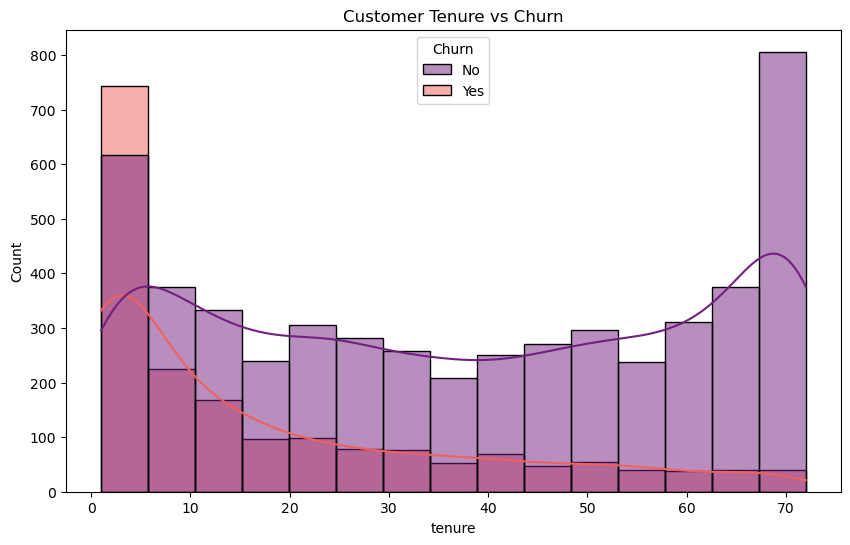

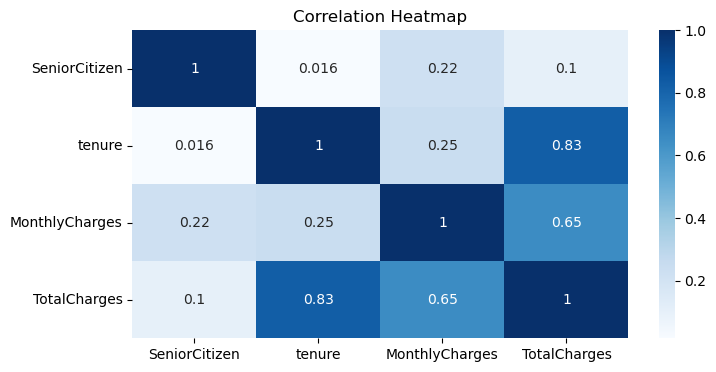

In [4]:
# ==========================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================

# Visual 1: Overall Churn Rate
churn_counts = df['Churn'].value_counts()
fig_pie = px.pie(values=churn_counts, names=churn_counts.index, 
                 title='Overall Churn Rate', color_discrete_sequence=['#3B82F6', '#EF4444'])
fig_pie.show()

# Visual 2: Tenure vs Churn
# This shows if newer customers are more likely to leave
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, palette='magma')
plt.title('Customer Tenure vs Churn')
plt.show()

# Visual 3: Correlation Heatmap (Numeric features only)
plt.figure(figsize=(8, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()

In [5]:
# ==========================================
# 4. FEATURE ENGINEERING & ENCODING
# ==========================================

# Encode the Target variable 'Churn'
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encode categorical variables using Label Encoding for simple model compatibility
# For a production app, we store these encoders to decode later if needed
le = LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns

for col in object_cols:
    df[col] = le.fit_transform(df[col])

In [6]:
# ==========================================
# 5. MODEL BUILDING
# ==========================================

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Save the model and scaler for the Gradio app
joblib.dump(rf_model, 'churn_model.pkl')
joblib.dump(scaler, 'churn_scaler.pkl')

['churn_scaler.pkl']

Accuracy Score: 0.7903340440653873

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



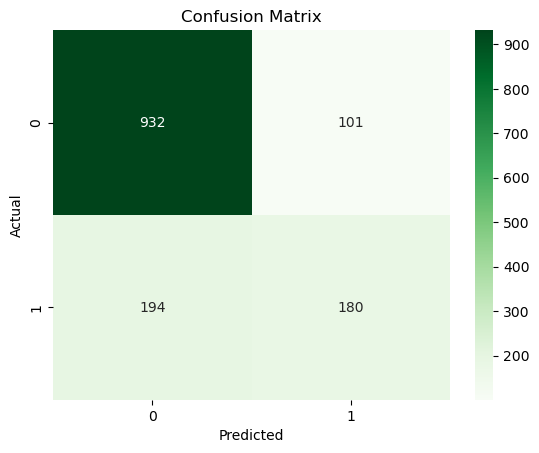

In [7]:
# ==========================================
# 6. EVALUATION
# ==========================================

y_pred = rf_model.predict(X_test_scaled)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visual
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# ==========================================
# 7. GRADIO DEPLOYMENT INTERFACE
# ==========================================

def predict_customer_churn(Gender, Senior, Partner, Dependents, Tenure, Monthly, Total):
    # Load assets
    model = joblib.load('churn_model.pkl')
    sc = joblib.load('churn_scaler.pkl')
    
    # Create a dummy array of all features (19 total in this dataset)
    # We map our main inputs and set others to median/default
    features = np.zeros(19)
    features[0] = 1 if Gender == "Male" else 0
    features[1] = 1 if Senior == "Yes" else 0
    features[2] = 1 if Partner == "Yes" else 0
    features[3] = 1 if Dependents == "Yes" else 0
    features[4] = Tenure
    features[17] = Monthly
    features[18] = Total
    
    prediction = model.predict(sc.transform([features]))[0]
    prob = model.predict_proba(sc.transform([features]))[0][1]
    
    result = "🔴 Likely to Churn" if prediction == 1 else "🟢 Likely to Stay"
    return f"{result} (Churn Probability: {prob:.2%})"

# Create Interface
app = gr.Interface(
    fn=predict_customer_churn,
    inputs=[
        gr.Dropdown(["Male", "Female"], label="Gender"),
        gr.Radio(["Yes", "No"], label="Senior Citizen"),
        gr.Radio(["Yes", "No"], label="Partner"),
        gr.Radio(["Yes", "No"], label="Dependents"),
        gr.Slider(0, 72, value=12, label="Tenure (Months)"),
        gr.Number(value=50.0, label="Monthly Charges"),
        gr.Number(value=500.0, label="Total Charges")
    ],
    outputs="text",
    title="Customer Churn Prediction Tool",
    description="Enter customer demographics and billing info to predict churn risk."
)

app.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


C:\Users\Syed Haider Ali\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\Syed Haider Ali\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



C:\Users\Syed Haider Ali\AppData\Local\Temp\ipykernel_14308\480023904.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Syed Haider Ali\AppData\Local\Temp\ipykernel_14308\480023904.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Syed Haider Ali\AppData\Local\Temp\ipykernel_14308\480023904.py:37: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



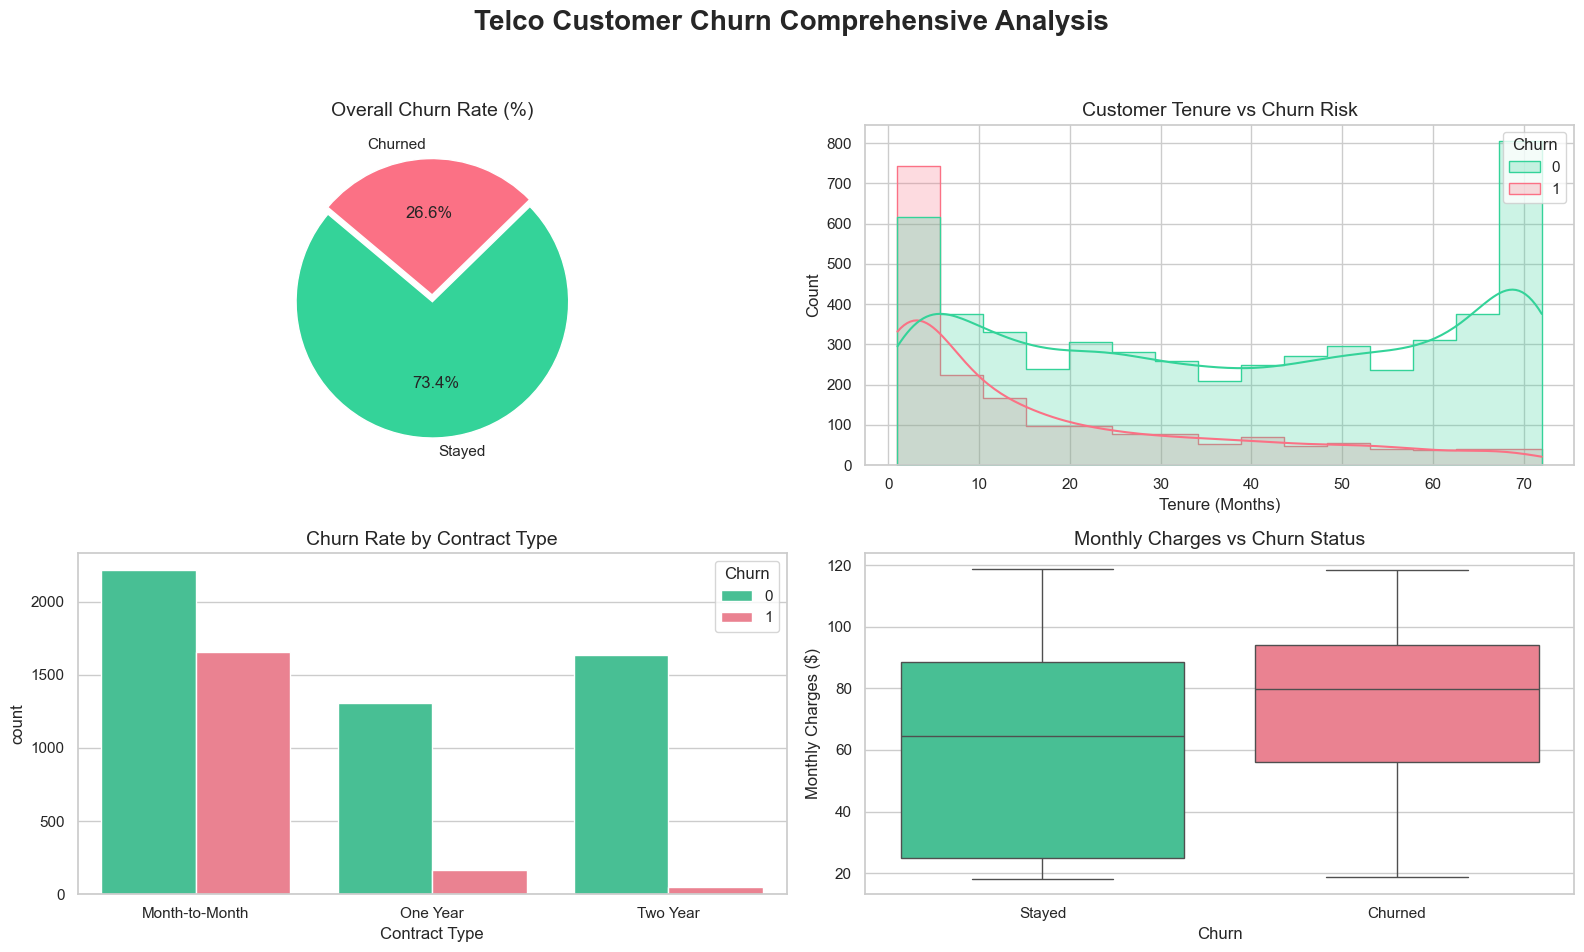

In [13]:
# ==========================================
# 8. STABLE ANALYTICAL DASHBOARD (Matplotlib/Seaborn)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Create a figure with a 2x2 grid of plots
fig, axes = plt.subplots(2, 2)
fig.suptitle('Telco Customer Churn Comprehensive Analysis', fontsize=20, fontweight='bold')

# --- Visual 1: Overall Churn Distribution ---
churn_data = df['Churn'].value_counts()
axes[0, 0].pie(churn_data, labels=['Stayed', 'Churned'], autopct='%1.1f%%', 
              startangle=140, colors=['#34D399', '#FB7185'], explode=(0.05, 0))
axes[0, 0].set_title('Overall Churn Rate (%)', fontsize=14)

# --- Visual 2: Tenure vs Churn (Histogram) ---
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, element="step", 
             palette=['#34D399', '#FB7185'], ax=axes[0, 1])
axes[0, 1].set_title('Customer Tenure vs Churn Risk', fontsize=14)
axes[0, 1].set_xlabel('Tenure (Months)')

# --- Visual 3: Contract Type impact ---
# Note: Mapping numbers back to text for the labels
contract_labels = {0: 'Month-to-Month', 1: 'One Year', 2: 'Two Year'}
sns.countplot(data=df, x='Contract', hue='Churn', palette=['#34D399', '#FB7185'], ax=axes[1, 0])
axes[1, 0].set_xticklabels([contract_labels[i] for i in sorted(df['Contract'].unique())])
axes[1, 0].set_title('Churn Rate by Contract Type', fontsize=14)
axes[1, 0].set_xlabel('Contract Type')

# --- Visual 4: Monthly Charges Distribution ---
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=['#34D399', '#FB7185'], ax=axes[1, 1])
axes[1, 1].set_xticklabels(['Stayed', 'Churned'])
axes[1, 1].set_title('Monthly Charges vs Churn Status', fontsize=14)
axes[1, 1].set_ylabel('Monthly Charges ($)')

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()